In [1]:
# section 1 load all the necessary modules and packages
import glob
import time
import netCDF4 as nc4 
import numpy as np
import pandas as pd
import xarray as xr
# not neccessary for the function but for visualziation
import matplotlib.pyplot as plt
import matplotlib
import warnings
import sys
import os
import platform
import shutil
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 30}
font = {'family' : 'Nimbus Roman',
        'weight' : 'bold',
        'size'   : 30}
matplotlib.rc('font', **font)


In [2]:
######################################
# create the scenario-A in a dataframe
######################################
obj_par = pd.read_csv('../mizuRoute_output_all_scenario_A/obj_par.csv')
obj_par = obj_par.sort_values(by='1_NSE')
obj_par = obj_par[obj_par['1_NSE']<0.5]

# df_A_volume
df_A_volume = pd.DataFrame()
df_A_outflow = pd.DataFrame()
for index, row in obj_par.iterrows():
    # volume
    ds = xr.open_dataset('../mizuRoute_output_all_scenario_A/sim_'+str(index+1).zfill(5)+'.nc')
    ds = ds['IRFvolume'][:,1] # lake victoria volume
    df = ds.to_dataframe()
    df['level_'+str(index+1).zfill(5)] = df['IRFvolume']/(68800*10**6) + 1122.86 # volume to elevation
    df = df.drop(columns=['IRFvolume'])
    df_A_volume = pd.concat([df_A_volume, df], axis=1)
    # outflow
    ds = xr.open_dataset('../mizuRoute_output_all_scenario_A/sim_'+str(index+1).zfill(5)+'.nc')
    ds = ds['IRFroutedRunoff'][:,0] # lake victoria outflow
    df = ds.to_dataframe()
    df['IRFroutedRunoff_'+str(index+1).zfill(5)] = df['IRFroutedRunoff']
    df = df.drop(columns=['IRFroutedRunoff'])
    df_A_outflow = pd.concat([df_A_outflow, df], axis=1)
    
df_A_outflow_best = df_A_outflow.iloc[:,0] # first column is highest NSE
df_A_volume_best  = df_A_volume.iloc [:,0] # first column is highest NSE

######################################
# create the scenario-B in a dataframe
######################################
obj_par = pd.read_csv('../mizuRoute_output_all_scenario_B/obj_par.csv')
obj_par = obj_par.sort_values(by='1_NSE')
obj_par = obj_par[obj_par['1_NSE']<0.5]

# df_B_volume
df_B_volume = pd.DataFrame()
df_B_outflow = pd.DataFrame()
for index, row in obj_par.iterrows():
    # volume
    ds = xr.open_dataset('../mizuRoute_output_all_scenario_B/sim_'+str(index+1).zfill(5)+'.nc')
    ds = ds['IRFvolume'][:,1] # lake victoria volume
    df = ds.to_dataframe()
    df['level_'+str(index+1).zfill(5)] = df['IRFvolume']/(68800*10**6) + 1122.86 # volume to elevation
    df = df.drop(columns=['IRFvolume'])
    df_B_volume = pd.concat([df_B_volume, df], axis=1)
    # outflow
    ds = xr.open_dataset('../mizuRoute_output_all_scenario_B/sim_'+str(index+1).zfill(5)+'.nc')
    ds = ds['IRFroutedRunoff'][:,0] # lake victoria outflow
    df = ds.to_dataframe()
    df['IRFroutedRunoff_'+str(index+1).zfill(5)] = df['IRFroutedRunoff']
    df = df.drop(columns=['IRFroutedRunoff'])
    df_B_outflow = pd.concat([df_B_outflow, df], axis=1)

df_B_outflow_best = df_B_outflow.iloc[:,0] # first column is highest NSE
df_B_volume_best  = df_B_volume.iloc [:,0] # first column is highest NSE

In [3]:
######################################
# simulation based on default parameters
######################################
ds_1 = xr.open_dataset('../mizuRoute_output_all_scenario_A/sim_hist.nc')
ds_2 = xr.open_dataset('../mizuRoute_output_all_scenario_A/sim_00001.nc')
ds_default = xr.merge([ds_1,ds_2])
df_default_outflow = ds_default['IRFroutedRunoff'][:,0] # lake victoria outflow
df_default_outflow = df_default_outflow.to_dataframe()
df_default_volume = ds_default['IRFvolume'][:,1] # lake victoria volume
df_default_volume = df_default_volume.to_dataframe()
df_default_volume['IRFvolume'] = df_default_volume['IRFvolume']/(68800*10**6) + 1122.86

######################################
# DAHITTI dataset
######################################
# read the Dahitti data set
lake_elevation = pd.read_csv('../data/DAHITI_Data/Lake_Victoria.csv')
lake_elevation['date']  = pd.DatetimeIndex(lake_elevation['date'])
lake_elevation = lake_elevation.set_index('date')
lake_elevation = lake_elevation.drop(columns=['error'])


0.8589015151515151 0.9249999999999999


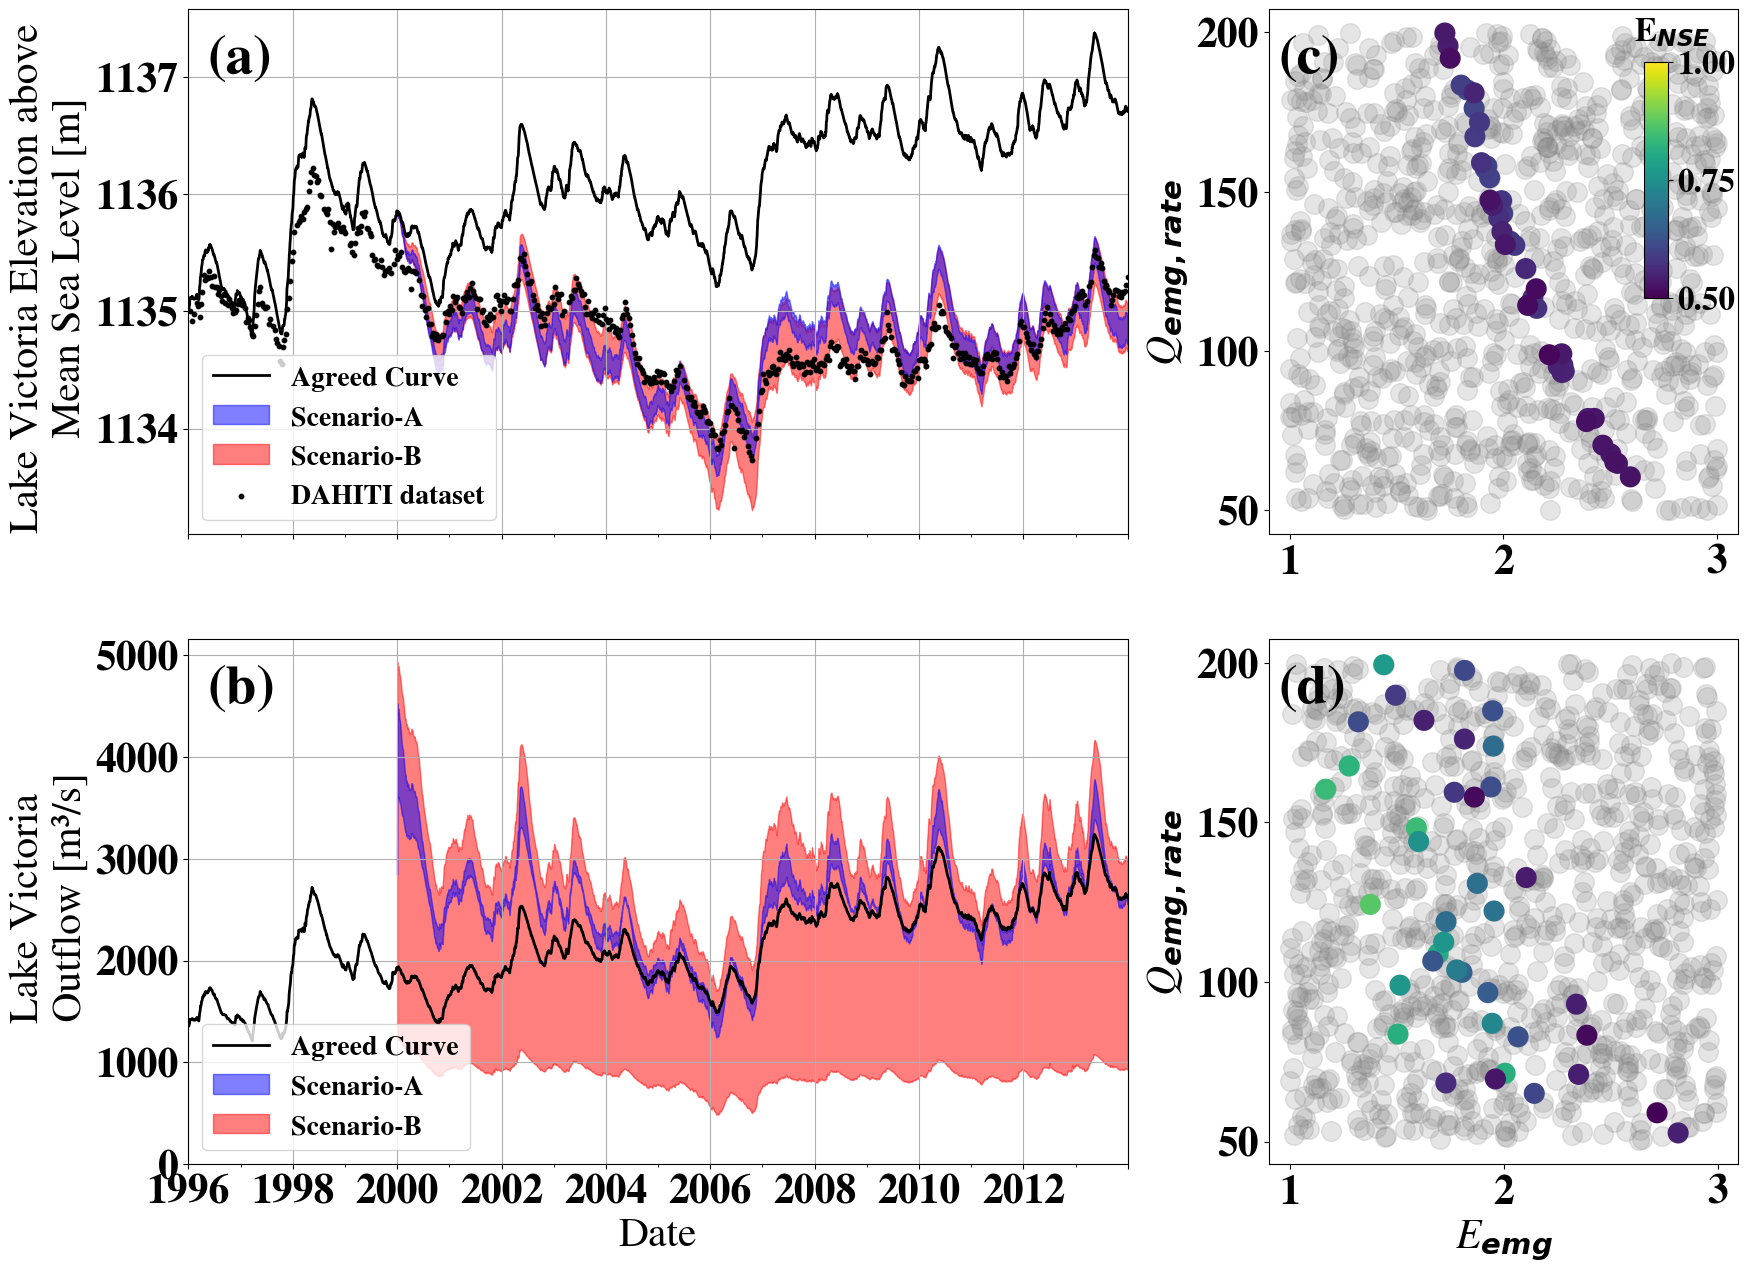

In [4]:
# plot stage values
fig, axes = plt.subplots(2, 2, figsize=(20, 15),
                         gridspec_kw={'wspace': 0.20,
                                      'hspace': 0.20,
                                      'width_ratios': [4, 2],
                                      'height_ratios': [2, 2]})

# Now you can access each individual axis using indexing, for example:
ax1 = axes[0, 0]
ax2 = axes[0, 1]
ax3 = axes[1, 0]
ax4 = axes[1, 1]

fig.patch.set_facecolor('white')

############################################
# plot lake level with various senacrios ax1
############################################
start_year = '1996-01-01'
end_year   = '2014-01-01'


# default simulation
df_default_volume_slice = df_default_volume[pd.Timestamp(start_year):pd.Timestamp(end_year)]
df_default_volume_slice['IRFvolume'].plot(ax=ax1,\
                                          linewidth = 2,\
                                          c = 'black',\
                                          label = 'Agreed Curve',\
                                          zorder = 3)

# plot behaviral parameters
df_A_volume_slice = df_A_volume[pd.Timestamp(start_year):pd.Timestamp(end_year)]
ax1.fill_between(df_A_volume_slice.index,\
                 df_A_volume_slice.quantile(0.05, axis =1),\
                 df_A_volume_slice.quantile(0.95, axis = 1),\
                 color='blue',\
                 alpha=.5,\
                 label='Scenario-A',
                 zorder = 1)

# plot behaviral parameters
df_B_volume_slice = df_B_volume[pd.Timestamp(start_year):pd.Timestamp(end_year)]
ax1.fill_between(df_B_volume_slice.index,\
                 df_B_volume_slice.quantile(0.05, axis =1),\
                 df_B_volume_slice.quantile(0.95, axis = 1),\
                 color='red',\
                 alpha=.5,\
                 label='Scenario-B',
                 zorder = 0)

# Observation
lake_elevation_slice = lake_elevation[pd.Timestamp(start_year):pd.Timestamp(end_year)]
ax1.scatter(lake_elevation_slice.index,\
            lake_elevation_slice.water_level,\
            s = 10,\
            c = 'black',\
            label = 'DAHITI dataset',\
            zorder = 4)

# legend and observation
ax1.grid(True)
ax1.legend(loc=3, fontsize=20)
ax1.set_xticklabels([])
ax1.set_ylabel('Lake Victoria Elevation above \n Mean Sea Level [m]')
ax1.set_xlabel(' ')
ax1.text(0.02, 0.95, '(a)', transform=ax1.transAxes, fontsize=40, verticalalignment='top')



############################################
# plot lake outflow with various senacrios ax3
############################################
start_year = '1996-01-01'
end_year   = '2014-01-01'


# default simulation
df_default_outflow_slice = df_default_outflow[pd.Timestamp(start_year):pd.Timestamp(end_year)]
df_default_outflow_slice['IRFroutedRunoff'].plot(ax=ax3,\
                                                 linewidth = 2,\
                                                 c = 'black',\
                                                 label = 'Agreed Curve',\
                                                 zorder = 3)

# plot behaviral parameters
df_A_outflow_slice = df_A_outflow[pd.Timestamp(start_year):pd.Timestamp(end_year)]
ax3.fill_between(df_A_outflow_slice.index,\
                 df_A_outflow_slice.quantile(0.05, axis =1),\
                 df_A_outflow_slice.quantile(0.95, axis = 1),\
                 color='blue',\
                 alpha=0.5,\
                 label='Scenario-A',
                 zorder = 1)

# plot behaviral parameters
df_B_outflow_slice = df_B_outflow[pd.Timestamp(start_year):pd.Timestamp(end_year)]
ax3.fill_between(df_B_outflow_slice.index,\
                 df_B_outflow_slice.quantile(0.05, axis =1),\
                 df_B_outflow_slice.quantile(0.95, axis = 1),\
                 color='red',\
                 alpha=0.5,\
                 label='Scenario-B',
                 zorder = 0)



# legend and observation
ax3.grid(True)
ax3.legend(loc=3, fontsize=20)
ax3.set_ylabel('Lake Victoria \n Outflow [m³/s]')
ax3.set_ylim(0,None)
ax3.set_xlabel('Date')
ax3.text(0.02, 0.95, '(b)', transform=ax3.transAxes, fontsize=40, verticalalignment='top')

############################
# create the dotty plots ax2
############################
obj_par = pd.read_csv('../mizuRoute_output_all_scenario_A/obj_par.csv')
obj_par['NSE'] = 1-obj_par['1_NSE']
obj_par = obj_par.sort_values(by='NSE', ascending=False)
obj_par = obj_par.reset_index()
obj_par2 = obj_par.copy()
obj_par2 = obj_par2 [obj_par2['NSE']>0.5]
ax2.scatter(obj_par['HYP_Erate_emr'],\
                     obj_par['HYP_Qrate_emr'],\
                     s=200,\
                     c='grey',\
                     alpha = 0.2)
sc2 = ax2.scatter(obj_par2['HYP_Erate_emr'],\
                     obj_par2['HYP_Qrate_emr'],\
                     c=obj_par2['NSE'],\
                     s=200,
                     vmin=0.5,vmax=1.0,cmap = 'viridis')
#ax4.set_xlabel('E$_{emg}$', fontdict={'fontstyle': 'italic'})
ax2.set_ylabel('Q$_{emg,rate}$', fontdict={'fontstyle': 'italic'})

# colorbar
cax2 = ax2.inset_axes([0.80, 0.45, 0.05, 0.45])  # Define color bar axis
cbar2 = plt.colorbar(sc2, cax=cax2)
label_text = 'E$_{NSE}$'
label_x = cax2.get_position().x0 + cax2.get_position().width / 2
label_y = cax2.get_position().y1 + 0.08  # Adjust the vertical position as needed
print(label_x, label_y)
ax2.text(label_x, label_y, label_text, ha='center', va='bottom', transform=ax2.transAxes, fontsize=24)
cbar2.ax.tick_params(axis='both', which='both', labelsize=24)
cbar2.set_ticks([0.50, 0.75, 1.00])
ax2.text(0.02, 0.95, '(c)', transform=ax2.transAxes, fontsize=40, verticalalignment='top')

###########################
# create the dotty plot ax4
###########################
obj_par = pd.read_csv('../mizuRoute_output_all_scenario_B/obj_par.csv')

ax4.scatter(obj_par['HYP_Erate_emr'],\
            obj_par['HYP_Qrate_emr'],\
            c='grey',\
            s=200,\
            alpha = 0.2)

obj_par['NSE'] = 1-obj_par['1_NSE']
obj_par = obj_par [obj_par['NSE']>0.5]

ax4.scatter(obj_par['HYP_Erate_emr'],\
            obj_par['HYP_Qrate_emr'],\
            c=obj_par['NSE'],\
            s=200,\
            vmin=0.5,\
            vmax=1.0,\
            cmap = 'viridis')

ax4.set_xlabel('E$_{emg}$', fontdict={'fontstyle': 'italic'})
ax4.set_ylabel('Q$_{emg,rate}$', fontdict={'fontstyle': 'italic'})
ax4.text(0.02, 0.95, '(d)', transform=ax4.transAxes, fontsize=40, verticalalignment='top')


#
if not os.path.isdir('../fig/'):
    os.makedirs('../fig/')
    
plt.savefig('../fig/lake_victoria_result.png')

In [5]:
obj_par = pd.read_csv('../mizuRoute_output_all_scenario_A/obj_par.csv')
obj_par = obj_par.sort_values(by='1_NSE')
obj_par = obj_par[obj_par['1_NSE']<0.5]
print('-----HYP_Erate_emr-------')
print(obj_par['HYP_Erate_emr'].min())
print(obj_par['HYP_Erate_emr'].max())
print('-----HYP_Qrate_emr-------')
print(obj_par['HYP_Qrate_emr'].min())
print(obj_par['HYP_Qrate_emr'].max())
print(1-obj_par['1_NSE'].head(1))

obj_par = pd.read_csv('../mizuRoute_output_all_scenario_B/obj_par.csv')
obj_par = obj_par.sort_values(by='1_NSE')
obj_par = obj_par[obj_par['1_NSE']<0.5]
print('-----HYP_Erate_emr-------')
print(obj_par['HYP_Erate_emr'].min())
print(obj_par['HYP_Erate_emr'].max())
print('-----HYP_Qrate_emr-------')
print(obj_par['HYP_Qrate_emr'].min())
print(obj_par['HYP_Qrate_emr'].max())
print('-----scale_factor_Ep_temp-------')
print(obj_par['scale_factor_Ep_temp'].min())
print(obj_par['scale_factor_Ep_temp'].max())
print('-----scale_factor_P_temp-------')
print(obj_par['scale_factor_P_temp'].min())
print(obj_par['scale_factor_P_temp'].max())
print(1-obj_par['1_NSE'].head(1))

-----HYP_Erate_emr-------
1.7254176387387907
2.5936373788445946
-----HYP_Qrate_emr-------
60.56312226021634
199.77119638826545
498    0.614187
Name: 1_NSE, dtype: float64
-----HYP_Erate_emr-------
1.1681495902331314
2.8158879523090112
-----HYP_Qrate_emr-------
52.712470808162855
199.4604085684234
-----scale_factor_Ep_temp-------
0.6099381002161157
1.381139496311676
-----scale_factor_P_temp-------
0.602962949261111
1.11061742402071
880    0.867812
Name: 1_NSE, dtype: float64


In [6]:
obj_par = pd.read_csv('../mizuRoute_output_all_scenario_A/sesitivity.csv')
print(obj_par)
obj_par = pd.read_csv('../mizuRoute_output_all_scenario_B/sesitivity.csv')
print(obj_par)

  Unnamed: 0  HYP_Erate_emr  HYP_Qrate_emr  scale_factor_Ep_temp  \
0      first       0.684384       0.115876              0.000556   
1      total       0.886551       0.181996              0.070529   

   scale_factor_P_temp  
0             0.009148  
1             0.131784  
  Unnamed: 0  HYP_Erate_emr  HYP_Qrate_emr  scale_factor_Ep_temp  \
0      first       0.375464       0.042175              0.087250   
1      total       0.774546       0.265261              0.299222   

   scale_factor_P_temp  
0             0.072639  
1             0.252290  
